In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Metric

from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class MatthewsCorrelationCoefficient(Metric):
    def __init__(self, name='mcc', **kwargs):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros', dtype='float32')
        self.false_positives = self.add_weight(name='fp', initializer='zeros', dtype='float32')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros', dtype='float32')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', dtype='float32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), 'int32')
        y_true = tf.cast(y_true, 'int32')
        true_positives = tf.math.count_nonzero(y_true * y_pred, axis=0)
        false_positives = tf.math.count_nonzero((1-y_true) * y_pred, axis=0)
        true_negatives = tf.math.count_nonzero((1-y_true) * (1-y_pred), axis=0)
        false_negatives = tf.math.count_nonzero(y_true * (1-y_pred), axis=0)
        self.true_positives.assign_add(tf.cast(tf.reduce_sum(true_positives), 'float32'))
        self.false_positives.assign_add(tf.cast(tf.reduce_sum(false_positives), 'float32'))
        self.true_negatives.assign_add(tf.cast(tf.reduce_sum(true_negatives), 'float32'))
        self.false_negatives.assign_add(tf.cast(tf.reduce_sum(false_negatives), 'float32'))

    def result(self):
        tp = self.true_positives
        tn = self.true_negatives
        fp = self.false_positives
        fn = self.false_negatives
        numerator = (tp * tn - fp * fn)
        denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        return tf.where(tf.equal(denominator, 0), 0.0, numerator / denominator)

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.true_negatives.assign(0)
        self.false_negatives.assign(0)


In [3]:
khz24 = pd.read_csv('khz24.csv')
train, test = train_test_split(khz24, test_size=0.13,shuffle=False)

In [4]:
khz24['label'].value_counts()

0    375251
1       567
Name: label, dtype: int64

In [4]:
train[train['label']!=0]

,time,24kHz,label
8006,2013-01-11 14:51:00,44.3739,1
8007,2013-01-11 14:52:00,44.2178,1
8008,2013-01-11 14:53:00,44.2159,1
8009,2013-01-11 14:54:00,44.2315,1
8010,2013-01-11 14:55:00,44.4830,1
...,...,...,...
325776,2013-11-18 14:31:00,41.5299,1
325777,2013-11-18 14:32:00,40.8891,1
325778,2013-11-18 14:33:00,40.9398,1
325779,2013-11-18 14:34:00,40.6085,1


In [5]:
test['label'].value_counts()

0    48806
1       51
Name: label, dtype: int64

In [6]:
test[test['label']==1]

,time,24kHz,label
332822,2013-11-23 12:05:00,40.3529,1
332823,2013-11-23 12:06:00,40.2161,1
332824,2013-11-23 12:07:00,40.1492,1
332825,2013-11-23 12:08:00,40.4161,1
332826,2013-11-23 12:09:00,39.9429,1
332827,2013-11-23 12:10:00,40.2620,1
332828,2013-11-23 12:11:00,40.8483,1
332829,2013-11-23 12:12:00,41.3177,1
332830,2013-11-23 12:13:00,40.6616,1
332831,2013-11-23 12:14:00,40.9768,1


In [4]:
train.to_csv('train_24.csv')
test.to_csv('test_24.csv')

In [5]:
train = pd.read_csv('train_24.csv')
test = pd.read_csv('test_24.csv')
train['time']=pd.to_datetime(train['time'])
test['time']=pd.to_datetime(test['time'])

test = test.dropna()
train = train.dropna()

#train['label+1']=train['label'].shift(periods=1)
#test['label+1']=test['label'].shift(periods=1)

#test = test.dropna()
#train = train.dropna()

#train['label+1']=train['label+1'].astype(int)
#test['label+1']=test['label+1'].astype(int)
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:].copy()
train = train.iloc[:-valid_size].copy()

In [6]:
y_train = train['label'].values.copy()
X_train = train['24kHz'].values.copy()
y_val = valid['label'].values.copy()
X_val = valid['24kHz'].values.copy()
y_test = test['label'].values.copy()
X_test = test['24kHz'].values.copy()

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((261569,), (261569,), (65392,), (65392,), (48857,), (48857,))

In [19]:
y_val.sum()

240

In [20]:
y_test.sum()

51

In [21]:
X_train

array([64.755 , 64.6402, 64.6167, ..., 34.5428, 34.4057, 34.5326])

In [7]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train.reshape(-1,1))

X_val_normalized = scaler.transform(X_val.reshape(-1,1))
X_test_normalized = scaler.transform(X_test.reshape(-1,1))

In [23]:
X_train_normalized

array([[0.89160485],
       [0.89009439],
       [0.88978519],
       ...,
       [0.49409369],
       [0.49228982],
       [0.49395948]])

In [8]:
n_input = 15  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= 1  # how many predictors/Xs/features we have to predict y
b_size = 128  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train_normalized, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val_normalized, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test_normalized, y_test, length=n_input, batch_size=128)

In [34]:
print(X_train_normalized[0:9])

[[0.93965594]
 [0.94058518]
 [0.94190869]
 [0.94231387]
 [0.94082053]
 [0.93990705]
 [0.93975784]
 [0.9401521 ]
 [0.94100856]]


In [36]:
print(y_train)

[     0      1      2 ... 263671 263672 263673]


In [39]:
for i in range(len(train_generator)):
 x, y = train_generator[i]
 print('%s => %s' % (x, y))

[[[0.93965594]
  [0.94058518]
  [0.94190869]
  ...
  [0.93390212]
  [0.93456934]
  [0.93563809]]

 [[0.94058518]
  [0.94190869]
  [0.94231387]
  ...
  [0.93456934]
  [0.93563809]
  [0.93677478]]

 [[0.94190869]
  [0.94231387]
  [0.94082053]
  ...
  [0.93563809]
  [0.93677478]
  [0.93665954]]

 ...

 [[0.81875551]
  [0.81916797]
  [0.8194021 ]
  ...
  [0.81918496]
  [0.81910004]
  [0.8190321 ]]

 [[0.81916797]
  [0.8194021 ]
  [0.81982791]
  ...
  [0.81910004]
  [0.8190321 ]
  [0.81870577]]

 [[0.8194021 ]
  [0.81982791]
  [0.81960712]
  ...
  [0.8190321 ]
  [0.81870577]
  [0.81810043]]] => [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [9]:
inputs = Input(shape=(15,1))
#a = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputs)
a = Bidirectional(LSTM(64, return_sequences=True, dropout=0.1))(inputs)
a = Flatten()(a)
b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(15,1))(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)
x = concatenate([a,b])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

2024-05-01 10:27:27.795360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7415 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:8b:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 13, 32)       128         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 6, 32)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4, 32)        3104        ['max_pooling1d[0][0]']          
                                                                                              

In [16]:
saved_model = "test.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [13]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
history = model.fit(train_generator, validation_data=val_generator, 
                    epochs=10, verbose=1, callbacks = callbacks_list, class_weight=class_weights)

NameError: name 'callbacks_list' is not defined

In [10]:
# Correct filepath string
filepath = "NN/test24kHz0105_epoch{epoch:04d}.hdf5"  # Updated to include epoch number
mcc_checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_mcc',
    mode='max',
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)

early = EarlyStopping(
    monitor='val_mcc',
    mode='max',
    patience=25,
    verbose=1
)

callbacks_list = [mcc_checkpoint, early]

# Make sure the model is correctly compiled and then fit it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MatthewsCorrelationCoefficient()])

# Assume y_train is your training labels and it's a numpy array or a list
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,  # Adjust this as needed
    verbose=1,
    callbacks=callbacks_list,
    class_weight=class_weights  # Apply the class weights here
)

#plot history, vybrat metriku

Epoch 1/20


2024-05-01 10:27:33.995097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


2044/2044 [==============================] - ETA: 0s - loss: 1.5203 - mcc: -0.0160
Epoch 1: saving model to NN/test24kHz0105_epoch0001.hdf5
2044/2044 [==============================] - 34s 14ms/step - loss: 1.5203 - mcc: -0.0160 - val_loss: 0.5296 - val_mcc: -0.0037
Epoch 2/20
2041/2044 [============================>.] - ETA: 0s - loss: 0.7022 - mcc: 0.0030
Epoch 2: saving model to NN/test24kHz0105_epoch0002.hdf5
2044/2044 [==============================] - 29s 14ms/step - loss: 0.7012 - mcc: 0.0030 - val_loss: 0.1566 - val_mcc: 0.0000e+00
Epoch 3/20
2041/2044 [============================>.] - ETA: 0s - loss: 1.1826 - mcc: -0.0085
Epoch 3: saving model to NN/test24kHz0105_epoch0003.hdf5
2044/2044 [==============================] - 30s 14ms/step - loss: 1.1812 - mcc: -0.0085 - val_loss: 0.3128 - val_mcc: 0.0000e+00
Epoch 4/20
2041/2044 [============================>.] - ETA: 0s - loss: 0.7268 - mcc: 0.0234
Epoch 4: saving model to NN/test24kHz0105_epoch0004.hdf5
2044/2044 [============

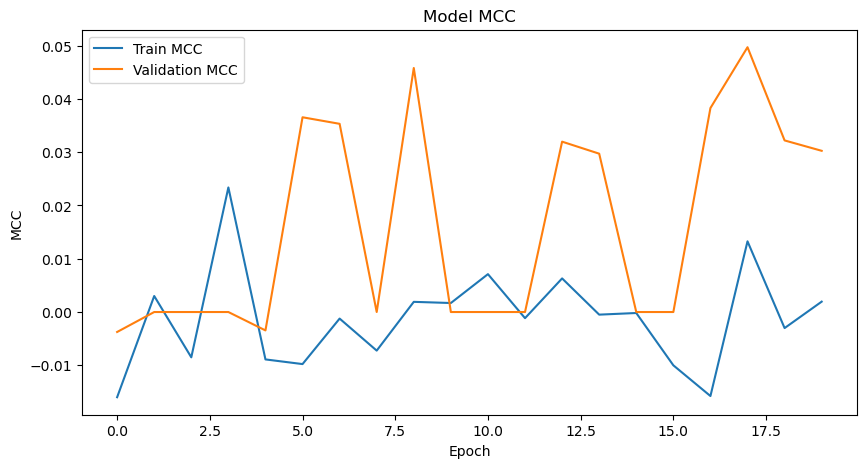

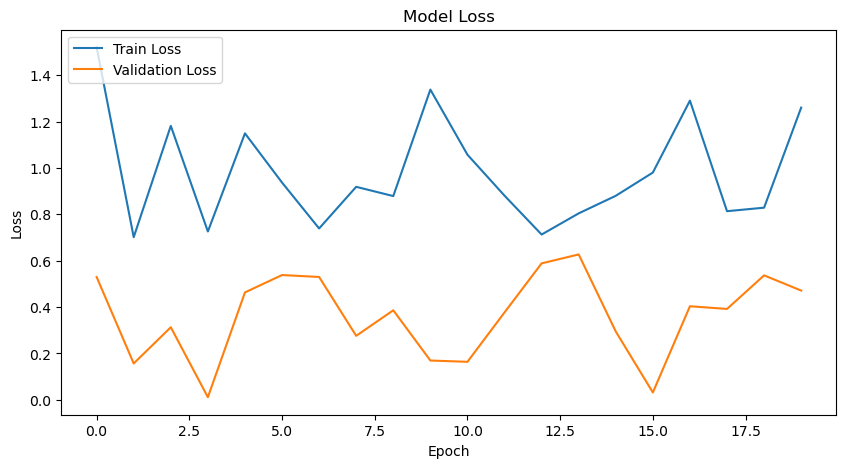

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mcc'], label='Train MCC')
plt.plot(history.history['val_mcc'], label='Validation MCC')
plt.title('Model MCC')
plt.ylabel('MCC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [23]:
print(class_weights)

{0: 0.5005281427363152, 1: 473.856884057971}


In [44]:
print(history)

NameError: name 'history' is not defined

In [31]:
with tf.keras.utils.custom_object_scope({'MatthewsCorrelationCoefficient': MatthewsCorrelationCoefficient}):
    model = load_model("NN/test234kHz0105_epoch0017.hdf5")

In [32]:
y_pred = model.predict(test_generator)

382/382 [==============================] - 2s 4ms/step


In [27]:
def optimal_threshold_by_mcc(y_true, y_pred_probs):
    """
    Determines the optimal threshold for binary classification based on the Matthew Correlation Coefficient (MCC).
    
    Parameters:
    - y_true: array-like of shape (n_samples,) - True labels of the data.
    - y_pred_probs: array-like of shape (n_samples,) - Predicted probabilities of the positive class.
    
    Returns:
    - optimal_threshold: The threshold value that maximizes the MCC.
    - max_mcc: The maximum MCC value obtained.
    """
    thresholds = np.linspace(0, 1, 1001)
    max_mcc = -1
    optimal_threshold = 0.5  # Default threshold in case MCC is never positive
    
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the current threshold
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate MCC for the current set of binary predictions
        mcc = matthews_corrcoef(y_true, y_pred)
        
        # Update optimal threshold if the current MCC is higher than what we've seen so far
        if mcc > max_mcc:
            max_mcc = mcc
            optimal_threshold = threshold
    
    print("max_mcc:", max_mcc)
    print("optimal_threshold:", optimal_threshold)
    return optimal_threshold


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix

def optimal_threshold_by_youden_index(y_true, y_pred_probs):
    """
    Determines the optimal threshold for binary classification based on the Youden Index.
    
    Parameters:
    - y_true: array-like of shape (n_samples,) - True labels of the data.
    - y_pred_probs: array-like of shape (n_samples,) - Predicted probabilities of the positive class.
    
    Returns:
    - optimal_threshold: The threshold value that maximizes the Youden Index.
    - max_youden_index: The maximum Youden Index value obtained.
    """
    thresholds = np.linspace(0, 1, 10001)
    max_youden_index = -1
    optimal_threshold = 0.5  # Default threshold in case Youden Index is never positive
    
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the current threshold
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate Sensitivity and Specificity
        sensitivity = tp / (tp + fn) if tp + fn != 0 else 0
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        
        # Calculate Youden Index
        youden_index = sensitivity + specificity - 1
        
        # Update optimal threshold if the current Youden Index is higher than what we've seen so far
        if youden_index > max_youden_index:
            max_youden_index = youden_index
            optimal_threshold = threshold
    
    print("max_youden_index:", max_youden_index)
    print("optimal_threshold:", optimal_threshold)
    return optimal_threshold



In [34]:
threshold = optimal_threshold_by_youden_index(y_test[15:], y_pred)
y_pred_bin = np.where(y_pred >= threshold, 1, 0).flatten()

max_youden_index: 0.35180668565924034
optimal_threshold: 0.5089


In [18]:
len(y_pred)

48842

In [19]:
y_pred.sum()

24350.432

In [20]:
len(y_pred_bin)

48842

In [19]:
len(y_pred)

46211

In [50]:
len(y_test)

46226

In [22]:
y_pred

array([[0.50579286],
       [0.50579286],
       [0.50579286],
       ...,
       [0.50579286],
       [0.50579286],
       [0.50579286]], dtype=float32)

In [61]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
test['label+1']

1        0
2        0
3        0
4        0
5        0
        ..
46221    0
46222    0
46223    0
46224    0
46225    0
Name: label+1, Length: 46225, dtype: int64

In [62]:
print(y_test[30:40])
print(y_pred_bin[30:])
y_pred_bin[30:].sum()

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 ... 1 1 1]


46166

In [35]:
print(classification_report(y_test[15:], y_pred_bin, zero_division=0))
print(confusion_matrix(y_test[15:], y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.35      0.52     48791
           1       0.00      1.00      0.00        51

    accuracy                           0.35     48842
   macro avg       0.50      0.68      0.26     48842
weighted avg       1.00      0.35      0.52     48842

[[17165 31626]
 [    0    51]]
